# Toy Models of Superposition

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/tms.ipynb)

Let's run through an example using Anthropic's toy models of superposition. 

This example is mostly to test that our SGLD estimator is working as expected and to figure out how to integrate this in an SGD setting.

Credits: [Chen et al. (2023)](https://arxiv.org/abs/2310.06301).

## Set-up
### Imports

In [2]:
!pip install devinterp scipy pyyaml pandas seaborn

In [1]:
import os
from typing import Iterable, Optional, Callable, List, Dict, Any
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import tqdm as tq
from tqdm.contrib.concurrent import process_map  # or use tqdm.contrib.concurrent.process_map if available

import itertools
from torch.utils.data import TensorDataset
from torch.nn import functional as F

from devinterp.slt.llc import estimate_learning_coeff_with_summary
from devinterp.optim.sgld import SGLD

class ToyAutoencoder(nn.Module):
    """
    Basic Network class for linear transformation with non-linear activations
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        tied: bool = True,
        final_bias: bool = False,
        hidden_bias: bool = False,
        nonlinearity: Callable = F.relu,
        unit_weights: bool = False,
        standard_magnitude: bool = False,
        initial_scale_factor: float = 1.0,
        initial_bias: Optional[torch.Tensor] = None,
        initial_embed: Optional[torch.Tensor] = None,
    ):
        super().__init__()

        # Set the dimensions and parameters
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nonlinearity = nonlinearity
        self.tied = tied
        self.final_bias = final_bias
        self.unit_weights = unit_weights
        self.standard_magnitude = standard_magnitude

        # Define the input layer (embedding)
        self.embedding = nn.Linear(self.input_dim, self.hidden_dim, bias=hidden_bias)

        # Set initial embeddings if provided
        if initial_embed is not None:
            self.embedding.weight.data = initial_embed

        # Define the output layer (unembedding)
        self.unembedding = nn.Linear(self.hidden_dim, self.input_dim, bias=final_bias)

        # Set initial bias if provided
        if initial_bias is not None:
            self.unembedding.bias.data = initial_bias

        # If standard magnitude is set, normalize weights and maintain average norm
        if self.standard_magnitude:
            avg_norm = torch.norm(self.embedding.weight.data, p=2, dim=0).mean()
            self.embedding.weight.data = (
                F.normalize(self.embedding.weight.data, p=2, dim=0) * avg_norm
            )

        # If unit weights is set, normalize weights
        if self.unit_weights:
            self.embedding.weight.data = F.normalize(self.embedding.weight.data, p=2, dim=0)

        # Tie the weights of embedding and unembedding layers
        if tied:
            self.unembedding.weight = torch.nn.Parameter(self.embedding.weight.transpose(0, 1))


    def forward(self, x: torch.Tensor):
        """
        Forward pass through the network
        """
        # Apply the same steps for weights as done during initialization
        if self.unit_weights:
            self.embedding.weight.data = F.normalize(self.embedding.weight.data, p=2, dim=0)

        if self.standard_magnitude:
            avg_norm = torch.norm(self.embedding.weight.data, p=2, dim=0).mean()
            self.embedding.weight.data = (
                F.normalize(self.embedding.weight.data, p=2, dim=0) * avg_norm
            )

        if self.tied:
            self.unembedding.weight.data = self.embedding.weight.data.transpose(0, 1)

        x = self.embedding(x)
        x = self.unembedding(x)
        x = self.nonlinearity(x)

        return x

"""
Adapted from [TMS-zoo](https://github.com/JakeMendel/TMS-zoo)
"""

from abc import ABC
from typing import Union

import torch
from torch.utils.data import Dataset


class SyntheticDataset(Dataset, ABC):
    num_samples: int
    num_features: int
    sparsity: Union[float, int]
    # importance: Optional[float]

    def __init__(
        self,
        num_samples,
        num_features,
        sparsity,
        # importance=None
    ):
        """
        Initialize the  object.

        Args:
            num_samples: The number of samples to generate.
            num_features: The dimension of the feature vector.
            sparsity: (float) the probability that a given feature is zero or (int) the number of features that are set to one.
            importance: The importance of the features. If None, then the features are weighted uniformly.
                        Otherwise, the features are weighted by `importance ** (1 + i)`, where `i` is the index of the feature.
        """
        self.num_samples = num_samples  # The number of samples in the dataset
        self.num_features = num_features  # The size of the feature vector for each sample
        self.sparsity = sparsity
        # self.importance = importance
        self.data = self.generate_data()  # Generate the synthetic data

    def generate_values(self):
        raise NotImplementedError

    def generate_mask(self):
        """
        Generate a sparse mask for the given dataset.

        If ``sparsity`` is a float, then the mask is generated by sampling from a Bernoulli distribution with parameter ``1 - sparsity``.
        If ``sparsity`` is an integer, then the mask is generated by sampling exactly ``sparsity`` indices without replacement.

        Args:
            dataset: The dataset to generate the mask for.

        Returns:
            A sparse mask for the given dataset.
        """

        if isinstance(self.sparsity, float):
            return torch.bernoulli(
                torch.ones((self.num_samples, self.num_features)) * (1 - self.sparsity)
            )
        elif isinstance(self.sparsity, int):
            mask = torch.zeros((self.num_samples, self.num_features))
            for i in range(self.num_samples):
                indices = torch.randperm(self.num_features)[: self.sparsity]
                mask[i, indices] = 1

            return mask

        else:
            raise ValueError(
                f"Sparsity must be a float or an integer. Received {type(self.sparsity)}."
            )

    def generate_data(self):
        return self.generate_mask() * self.generate_values()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]


class SyntheticUniformValued(SyntheticDataset):
    """
    This class creates a synthetic dataset where each sample is a vector which has indices which are zero with probability sparsity and uniform between 0 and 1 otherwise
    """

    def generate_values(self):
        return torch.rand((self.num_samples, self.num_features))


class SyntheticBinaryValued(SyntheticDataset):
    """
    This class creates a synthetic dataset where each sample is a vector which has indices which are zero with probability ``sparsity`` and 1 otherwise
    """

    def generate_values(self):
        return 1.0


/tmp/ipykernel_2447006/2162266759.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Environmental variables

In [2]:
torch.manual_seed(1)

DEVICE = os.environ.get(
    "DEVICE",
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu",
)
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))

### K-gon Plotting Utils

In [3]:
def generate_2d_kgon_vertices(k, rot=0., pad_to=None, force_length=0.9):
    """Set the weights of a 2D k-gon to be the vertices of a regular k-gon."""
    # Angles for the vertices
    theta = np.linspace(0, 2*np.pi, k, endpoint=False) + rot

    # Generate the vertices
    x = np.cos(theta)
    y = np.sin(theta)
    result = np.vstack((x, y))

    if pad_to is not None and k < pad_to:
        num_pad = pad_to - k
        result = np.hstack([result, np.zeros((2, num_pad))])
        
    return (result * force_length)

def generate_init_param(m, n, init_kgon, prior_std=1., no_bias=True, init_zerobias=True, seed=0, force_negb=False, noise=0.01):
    np.random.seed(seed)
    
    if init_kgon is None or m != 2:
        init_W = np.random.normal(size=(m, n)) * prior_std
    else:
        assert init_kgon <= n
        rand_angle = np.random.uniform(0, 2 * np.pi, size=(1,))
        noise = np.random.normal(size=(m, n)) * noise
        init_W = generate_2d_kgon_vertices(init_kgon, rot=rand_angle, pad_to=n) + noise
    
    if no_bias:
        param = {"W": init_W}
    else:
        init_b = np.random.normal(size=(n, 1)) * prior_std
        if force_negb:
            init_b = -np.abs(init_b)
        if init_zerobias:
            init_b = init_b * 0
        param = {
            "W": init_W, 
            "b": init_b
        }
    return param

In [4]:
def plot_polygon(
    W: torch.Tensor,
    b=None,
    ax=None,
    ax_bias=None,
    ax_wnorm=None,
    hull_alpha=0.3,
    dW=None,
    dW_scale=0.3,
    orderb=True,
    color="b",
):
    """Credits: Edmund Lau"""
    if ax is None:
        if W.shape[0] == 2:
            fig, ax = plt.subplots(1, 1)
        elif W.shape[0] == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")

    if W.shape[0] == 2:  # 2D case
        # Compute the norms of the columns
        norms = np.linalg.norm(W, axis=0)

        # Normalize a copy of the vectors for angle calculations
        W_normalized = W / norms

        # Compute angles from the x-axis for each vector
        angles = np.arctan2(W_normalized[1, :], W_normalized[0, :])

        # Sort the columns of W by angles
        order = np.argsort(angles)
        W_sorted = W[:, order]

        # Plot the origin
        ax.scatter(0, 0, color="red")

        # Plot the vectors
        for i in range(W_sorted.shape[1]):
            ax.quiver(
                0,
                0,
                W_sorted[0, i],
                W_sorted[1, i],
                angles="xy",
                scale_units="xy",
                scale=1,
                width=0.003,
            )
        if dW is not None:
            dW = -dW_scale * dW / np.max(np.linalg.norm(dW, axis=0))
            for col in range(W.shape[1]):
                ax.quiver(
                    W[0, col],
                    W[1, col],
                    dW[0, col],
                    dW[1, col],
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    color="r",
                    width=0.005,
                )

        # Connect the vectors to form a polygon
        polygon = np.column_stack((W_sorted, W_sorted[:, 0]))
        ax.plot(polygon[0, :], polygon[1, :], alpha=0.5)

        # Plot the convex hull
        hull = ConvexHull(W.T)
        vs = list(hull.vertices) + [hull.vertices[0]]
        ax.plot(W[0, vs], W[1, vs], "r--", alpha=hull_alpha)

        # Set the aspect ratio of the plot to equal to ensure that angles are displayed correctly
        ax.set_aspect("equal", adjustable="box")

    elif W.shape[0] == 3:  # 3D case
        # Plot the origin
        ax.scatter([0], [0], [0], color="red")

        # Plot the vectors
        for i in range(W.shape[1]):
            ax.plot([0, W[0, i]], [0, W[1, i]], [0, W[2, i]], color)

        # Plot the convex hull
        hull = ConvexHull(W.T)
        for s in hull.simplices:
            s = np.append(s, s[0])  # Here we cycle back to the first coordinate
            ax.plot(W[0, s], W[1, s], W[2, s], "r--", alpha=hull_alpha)
    else:
        raise ValueError("W must have either 2 or 3 rows")

    if b is not None and ax_bias is not None:
        b_plot = np.ravel(b)
        if orderb:
            b_plot = b_plot[order]
        bar_colors = ["r" if val < 0 else "b" for val in b_plot]
        yticks = np.array(range(1, len(b_plot) + 1))
        ax_bias.barh(
            yticks - 0.4,
            np.abs(b_plot),
            height=0.4,
            color=bar_colors,
            align="edge",
        )
        ax_bias.set_yticks(yticks)
        ax_bias.yaxis.tick_right()
        ax_bias.tick_params(axis="y", labelsize="x-small")
        ax_bias.tick_params(axis="x", labelsize="x-small")

    if ax_wnorm is not None:
        yticks = np.array(range(1, W.shape[1] + 1))
        wnorms = np.linalg.norm(W, axis=0)
        if orderb:
            wnorms = wnorms[order]
        ax_wnorm.barh(yticks, width=wnorms, height=0.4, color="black", alpha=0.9, align="edge")
    return ax


def plot_polygons(Ws, axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, len(Ws), figsize=(15, 4))

    for ax, W in zip(axes, Ws):
        plot_polygon(W, ax=ax)


def plot_losses_and_polygons(steps, losses, highlights, Ws,xscale="log", yscale="log",batch_size=None, run=None):
    fig = plt.figure(figsize=(15, 6))

    gs = fig.add_gridspec(2, len(Ws))
    ax_losses = fig.add_subplot(gs[1, :])
    ax_polygons = []

    max_x, min_x = max([np.max(W[0]) for W in Ws]), min([np.min(W[0]) for W in Ws])
    max_y, min_y = max([np.max(W[1]) for W in Ws]), min([np.min(W[1]) for W in Ws])

    for i in range(len(Ws)):
        ax = fig.add_subplot(gs[0, i], adjustable='box') 
        ax.set_aspect('equal')
        ax_polygons.append(ax)
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)

    ax_losses.plot(steps, losses)
    ax_losses.set_xlabel("Step")
    ax_losses.set_ylabel("Loss")
    ax_losses.set_xscale(xscale)
    ax_losses.set_yscale(yscale)

    for i, step in enumerate(highlights):
        ax_losses.axvline(step, color="gray", linestyle="--")

    plot_polygons(Ws, ax_polygons)
    batch_size_str = f"Batch size: {batch_size}" if batch_size is not None else ""
    run_str = f"Run: {run}" if run is not None else ""
    plt.suptitle("Loss and Weight snapshots, " + batch_size_str + " " + run_str)
    plt.tight_layout()


<Axes: >

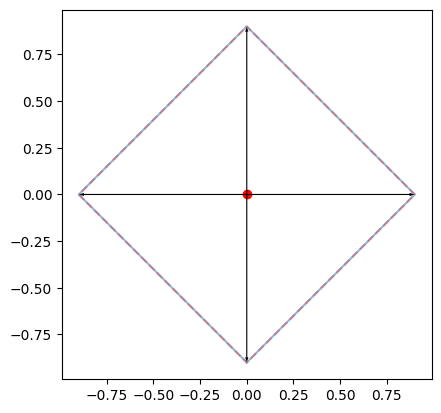

In [5]:
plot_polygon(generate_2d_kgon_vertices(4))

### Training loop

In [6]:
def create_and_train(
    m: int,
    n: int,
    num_samples: int,
    batch_size: Optional[int] = 1,
    num_epochs: int = 100,
    lr: float = 0.001,
    log_ivl: Iterable[int] = [],
    device=DEVICE,
    momentum=0.9,
    weight_decay=0.0,
    init_kgon=None,
    no_bias=False,
    init_zerobias=False,
    prior_std=10.,
    seed=0,
):
    model = ToyAutoencoder(m, n, final_bias=True)

    init_weights = generate_init_param(n, m, init_kgon, no_bias=no_bias, init_zerobias=init_zerobias, prior_std=prior_std, seed=seed)
    model.embedding.weight.data = torch.from_numpy(init_weights["W"]).float()
    
    if "b" in init_weights:
        model.unembedding.bias.data = torch.from_numpy(init_weights["b"].flatten()).float()

    dataset = SyntheticBinaryValued(num_samples, m, 1)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    logs = pd.DataFrame([{"loss": None, "acc": None, "step": step} for step in log_ivl])

    model.to(device)
    weights = []

    def log(step):
        loss = 0.0
        acc = 0.0
        length = 0

        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(device)
                outputs = model(batch)
                loss += criterion(outputs, batch).item()
                acc += (outputs.round() == batch).float().sum().item()
                length += len(batch)

        loss /= length
        acc /= length

        logs.loc[logs["step"] == step, ["loss", "acc"]] = [loss, acc]
        weights.append({k: v.cpu().detach().clone().numpy() for k, v in model.state_dict().items()})

    step = 0
    log(step)

    for epoch in tqdm(range(num_epochs), desc="Training"):
        for batch in dataloader:
            batch = batch.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch)
            loss = criterion(outputs, batch)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            step += 1

            if step in log_ivl:
                log(step)

    return logs, weights

## Training

In [7]:
NUM_FEATURES = 6
NUM_HIDDEN_UNITS = 2
NUM_SAMPLES = 1024
NUM_EPOCHS = 4500
INIT_KGON = 4
NUM_OBSERVATIONS = 50 #originally 50 

STEPS = sorted(list(set(np.logspace(0, np.log10(NUM_EPOCHS), NUM_OBSERVATIONS).astype(int))))
PLOT_STEPS = [min(STEPS, key=lambda s: abs(s-i)) for i in [0, 200, 500, 1000, NUM_EPOCHS - 1]] #originally [0, 200, 2000, 10000, NUM_EPOCHS - 1]
PLOT_INDICES = [STEPS.index(s) for s in PLOT_STEPS]

- v1.4.0: first version with settings like in the optimization paper.
- v1.5.0: 4500 epochs. 50 runs. 
- v1.6.0: 20K epochs instead of 4500 epochs

In [8]:
import os
import pickle

version = "v1.5.0"
num_runs = 25
batch_sizes = [2**n for n in range(10,-1,-1)] #NOTE: 128-1024 are in v1.3.0


def save_individual_results(batch_size, run, run_logs, run_weights):
    os.makedirs("results", exist_ok=True)
    with open(f"results/batch_logs_{batch_size}_run_{run}_{version}.pkl", "wb") as f:
        pickle.dump(run_logs, f)
    with open(f"results/batch_weights_{batch_size}_run_{run}_{version}.pkl", "wb") as f:
        pickle.dump(run_weights, f)

def aggregate_and_save_results(batch_size):
    all_logs = []
    all_weights = []
    for run in range(num_runs):
        with open(f"results/batch_logs_{batch_size}_run_{run}_{version}.pkl", "rb") as f:
            run_logs = pickle.load(f)
        with open(f"results/batch_weights_{batch_size}_run_{run}_{version}.pkl", "rb") as f:
            run_weights = pickle.load(f)
        all_logs.append(run_logs)
        all_weights.append(run_weights)

    # Save aggregated results in a single file
    with open(f"results/batch_logs_{batch_size}_{version}.pkl", "wb") as f:
        pickle.dump(all_logs, f)
    with open(f"results/batch_weights_{batch_size}_{version}.pkl", "wb") as f:
        pickle.dump(all_weights, f)

# Dictionary to store aggregated results for all batch sizes
aggregated_logs = {}
aggregated_weights = {}

for batch_size in batch_sizes:
    for run in range(num_runs):
        result_log_file = f"results/batch_logs_{batch_size}_run_{run}_{version}.pkl"
        if not os.path.exists(result_log_file):
            print(f"Running batch size {batch_size} for run {run}...")
            run_logs, run_weights = create_and_train(NUM_FEATURES, NUM_HIDDEN_UNITS, num_samples=NUM_SAMPLES, log_ivl=STEPS, batch_size=batch_size, lr=0.01, num_epochs=NUM_EPOCHS, init_kgon=INIT_KGON, init_zerobias=False, seed=run)
            
            # Save the results for this run
            save_individual_results(batch_size, run, run_logs, run_weights)

    # Aggregate results after all runs are completed for this batch size
    aggregate_and_save_results(batch_size)
    with open(f"results/batch_logs_{batch_size}_{version}.pkl", "rb") as f:
        aggregated_logs[batch_size] = pickle.load(f)
    with open(f"results/batch_weights_{batch_size}_{version}.pkl", "rb") as f:
        aggregated_weights[batch_size] = pickle.load(f)

# Save the aggregated results for all batch sizes
with open(f"results/batch_logs_{version}.pkl", "wb") as f:
    pickle.dump(aggregated_logs, f)
with open(f"results/batch_weights_{version}.pkl", "wb") as f:
    pickle.dump(aggregated_weights, f)
with open(f"results/batch_sizes_{version}.pkl", "wb") as f:
    pickle.dump(batch_sizes, f)

In [9]:
batch_logs = {}
batch_weights = {}
batch_sizes = []

for version in ["v1.5.0"]:
    with open(f"results/batch_logs_{version}.pkl", "rb") as f:
        batch_logs.update(pickle.load(f))
    with open(f"results/batch_weights_{version}.pkl", "rb") as f:
        batch_weights.update(pickle.load(f))
    with open(f"results/batch_sizes_{version}.pkl", "rb") as f:
        batch_sizes.extend(pickle.load(f))
        batch_sizes = sorted(list(set(batch_sizes)))

In [10]:
embedding_weights = {k:[[w[i]['embedding.weight'] for i in range(len(w)) if i!=0] for w in b] for k,b in batch_weights.items()}

In [11]:
len(STEPS)

44

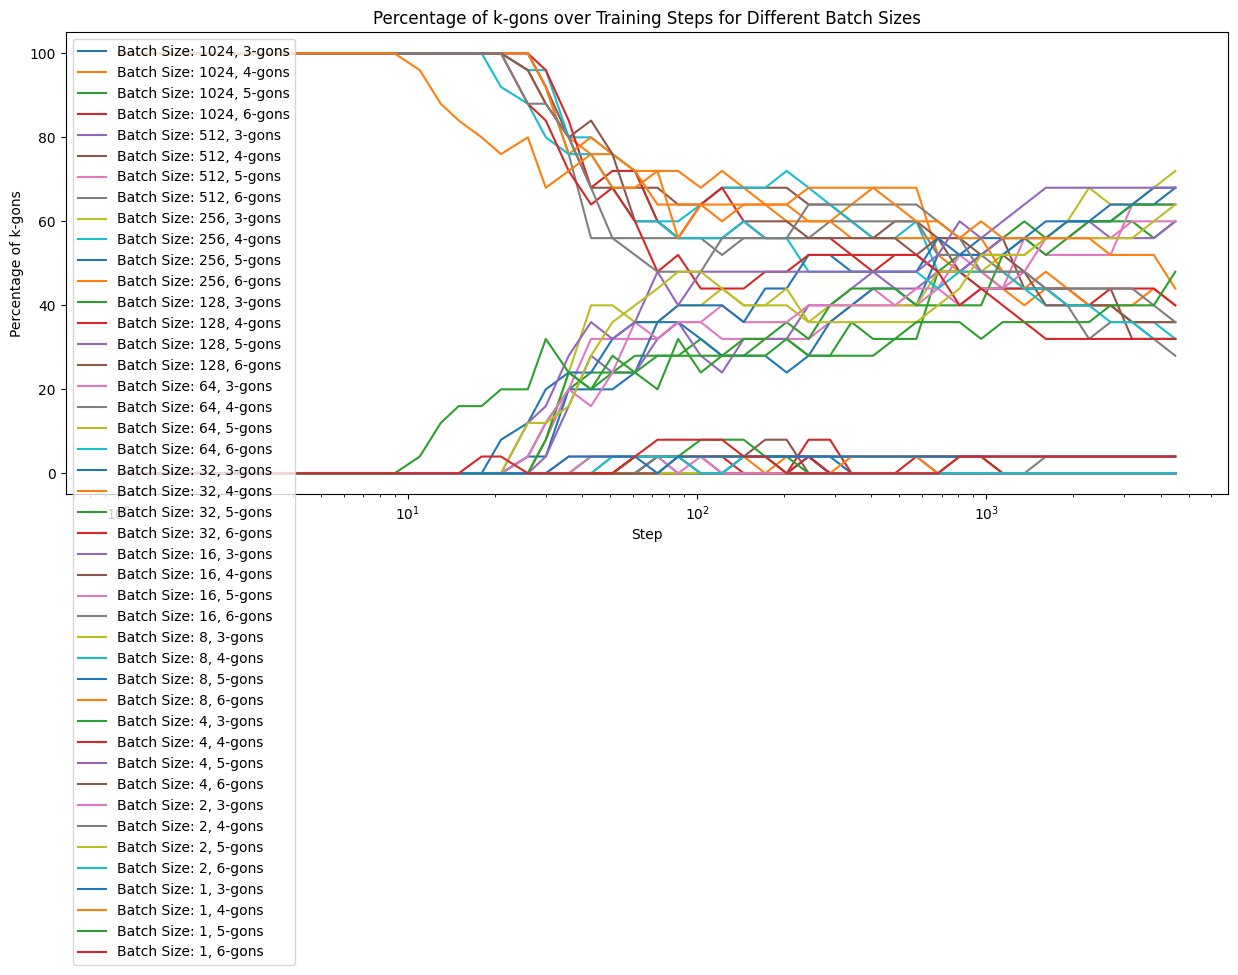

In [12]:
def calculate_convex_hull_vertices(W):
    """
    Calculate the number of vertices of the convex hull of the points represented by the columns of W.
    
    Parameters:
    W (torch.Tensor): A 2xN matrix where each column represents a point in 2D space.
    
    Returns:
    int: The number of vertices of the convex hull.
    """
    if W.shape[0] != 2:
        raise ValueError("The weight matrix W must have 2 rows.")
    
    # Convert the tensor to a numpy array if it isn't already
    if isinstance(W, torch.Tensor):
        W = W.cpu().detach().numpy()
    
    hull = ConvexHull(W.T)
    return len(hull.vertices)  # The number of vertices is the same as the number of edges

def count_convex_hull_edges(W):
    """
    Count the occurrences of convex hull edges in a list of weight matrices.

    Parameters:
    W (list of torch.Tensor): A list where each item is a 2xN weight matrix.

    Returns:
    dict: A dictionary with the number of edges as keys and the count as values.
    """
    edge_counts = {}
    
    # Process each weight matrix
    for weights in W:
        num_edges = calculate_convex_hull_vertices(weights)
        if num_edges in edge_counts:
            edge_counts[num_edges] += 1
        else:
            edge_counts[num_edges] = 1

    return edge_counts

def plot_percentage_of_kgons_over_time(batch_weights, steps):
    plt.figure(figsize=(15, 6))
    
    # Create a dictionary to store percentages of k-gons for each batch size
    kgon_percentages = {batch_size: [] for batch_size in batch_weights.keys()}
    
    # Iterate over each batch size
    for batch_size, runs_weights in batch_weights.items():
        # Iterate over each time step
        for step_weights in zip(*runs_weights):  # This transposes the list of lists
            edge_counts = count_convex_hull_edges(step_weights)
            total_counts = sum(edge_counts.values())
            # Calculate percentages
            for k, count in edge_counts.items():
                edge_counts[k] = (count / total_counts) * 100
            kgon_percentages[batch_size].append(edge_counts)
        
        # Plot the percentage of k-gons over time for each batch size
        for k in range(3, 7):  # Assuming you are interested in 3-gons to 6-gons
            percentages = [step.get(k, 0) for step in kgon_percentages[batch_size]]
            
            plt.plot(steps, percentages, label=f'Batch Size: {batch_size}, {k}-gons')
    
    plt.xlabel('Step')
    plt.ylabel('Percentage of k-gons')
    plt.xscale('log')
    plt.title('Percentage of k-gons over Training Steps for Different Batch Sizes')
    plt.legend()
    plt.show()

# Assuming 'batch_weights' is your dictionary of weights, 'STEPS' is your list of timesteps
plot_percentage_of_kgons_over_time(embedding_weights, STEPS)


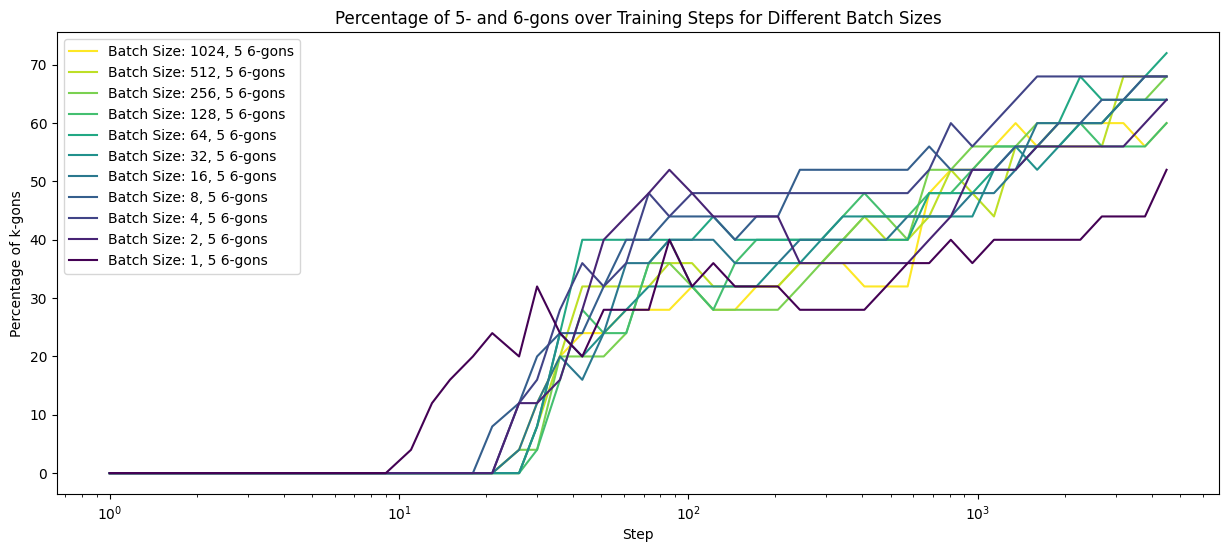

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_percentage_of_kgons_over_time(batch_weights, steps, k_values=[5, 6]):
    plt.figure(figsize=(15, 6))
    
    # Generate a color map to represent different batch sizes with a color gradient
    batch_sizes = sorted(batch_weights.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(batch_sizes)))
    
    # Create a dictionary to store percentages of k-gons for each batch size
    kgon_percentages = {batch_size: {k: [] for k in k_values} for batch_size in batch_sizes}
    
    # Iterate over each batch size
    for batch_size, runs_weights in batch_weights.items():
        # Get the color for the current batch size
        color = colors[batch_sizes.index(batch_size)]
        
        # Iterate over each time step
        for step_weights in zip(*runs_weights):  # This transposes the list of lists
            edge_counts = count_convex_hull_edges(step_weights)
            total_counts = sum(edge_counts.values())
            
            # Calculate percentages for interested k-gons
            for k in k_values:
                percentage = (edge_counts.get(k, 0) / total_counts) * 100
                kgon_percentages[batch_size][k].append(percentage)
        
        # Plot the percentage of k-gons over time for each k-value
        percentages = np.zeros(len(steps))
        for k in k_values:
            percentages += kgon_percentages[batch_size][k]
        label = f'Batch Size: {batch_size}, {" ".join([str(k) for k in k_values])}-gons'
        plt.plot(steps, percentages, label=label, color=color)
        

    plt.xlabel('Step')
    plt.ylabel('Percentage of k-gons')
    plt.xscale('log')
    plt.title('Percentage of 5- and 6-gons over Training Steps for Different Batch Sizes')
    plt.legend()
    plt.show()
    

# Assuming 'batch_weights' is your dictionary of weights, 'STEPS' is your list of timesteps
plot_percentage_of_kgons_over_time(embedding_weights, STEPS)


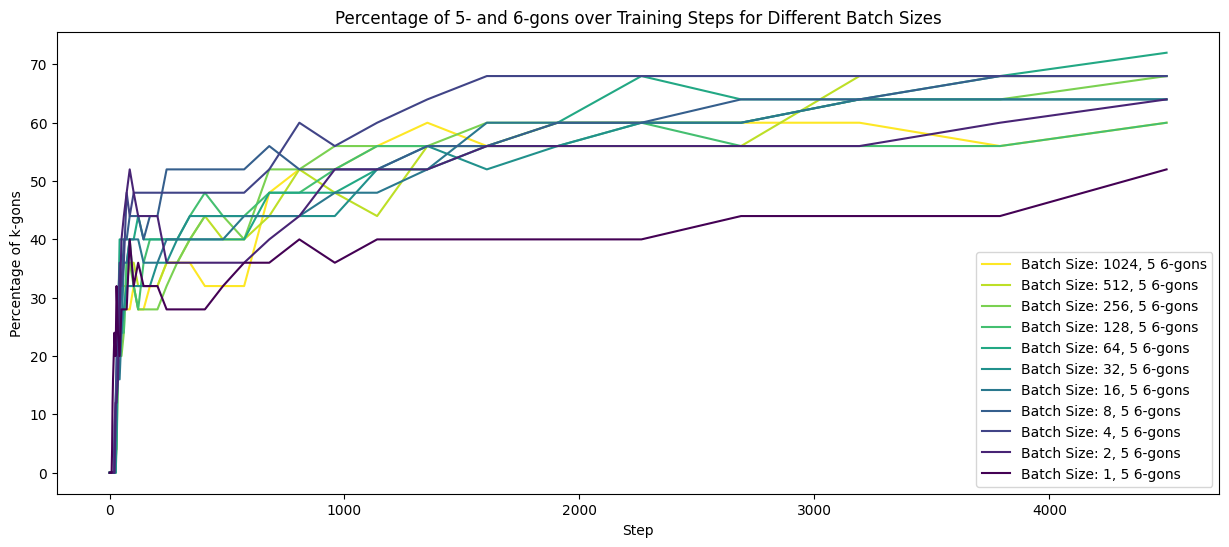

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_percentage_of_kgons_over_time(batch_weights, steps, k_values=[5, 6]):
    plt.figure(figsize=(15, 6))
    
    # Generate a color map to represent different batch sizes with a color gradient
    batch_sizes = sorted(batch_weights.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(batch_sizes)))
    
    # Create a dictionary to store percentages of k-gons for each batch size
    kgon_percentages = {batch_size: {k: [] for k in k_values} for batch_size in batch_sizes}
    
    # Iterate over each batch size
    for batch_size, runs_weights in batch_weights.items():
        # Get the color for the current batch size
        color = colors[batch_sizes.index(batch_size)]
        
        # Iterate over each time step
        for step_weights in zip(*runs_weights):  # This transposes the list of lists
            edge_counts = count_convex_hull_edges(step_weights)
            total_counts = sum(edge_counts.values())
            
            # Calculate percentages for interested k-gons
            for k in k_values:
                percentage = (edge_counts.get(k, 0) / total_counts) * 100
                kgon_percentages[batch_size][k].append(percentage)
        
        # Plot the percentage of k-gons over time for each k-value
        percentages = np.zeros(len(steps))
        for k in k_values:
            percentages += kgon_percentages[batch_size][k]
        label = f'Batch Size: {batch_size}, {" ".join([str(k) for k in k_values])}-gons'
        plt.plot(steps, percentages, label=label, color=color)
        

    plt.xlabel('Step')
    plt.ylabel('Percentage of k-gons')
    plt.xscale('linear')
    plt.title('Percentage of 5- and 6-gons over Training Steps for Different Batch Sizes')
    plt.legend()
    plt.show()
    

# Assuming 'batch_weights' is your dictionary of weights, 'STEPS' is your list of timesteps
plot_percentage_of_kgons_over_time(embedding_weights, STEPS)


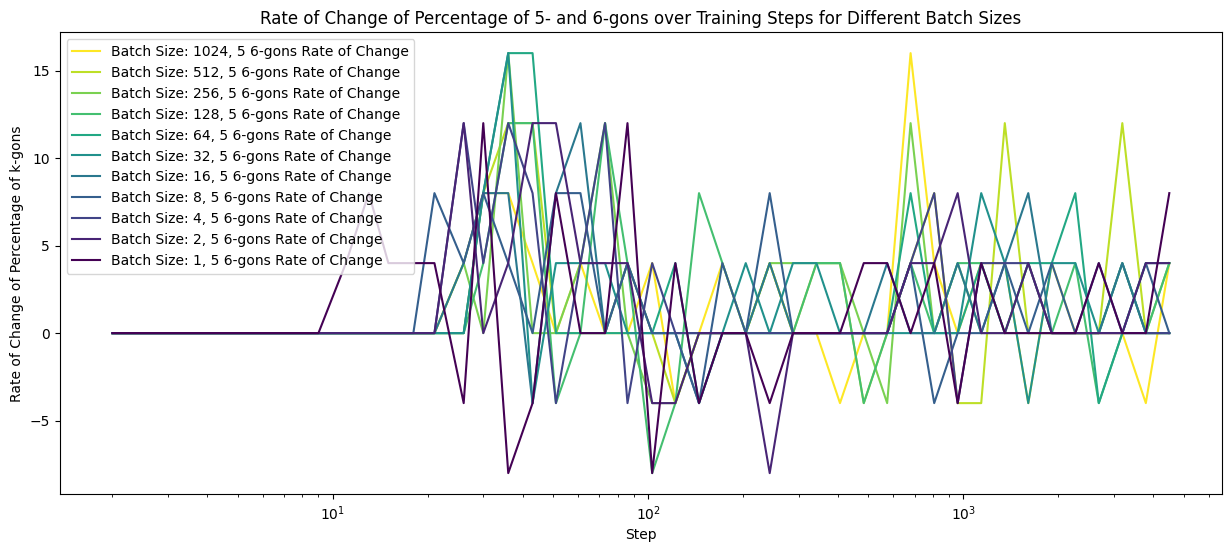

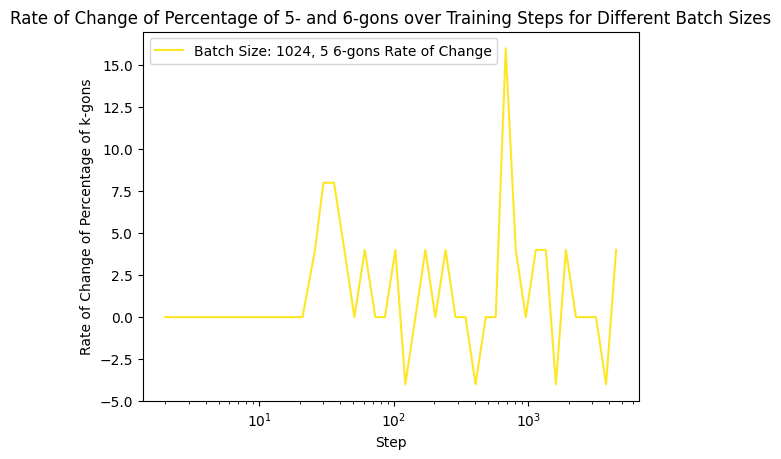

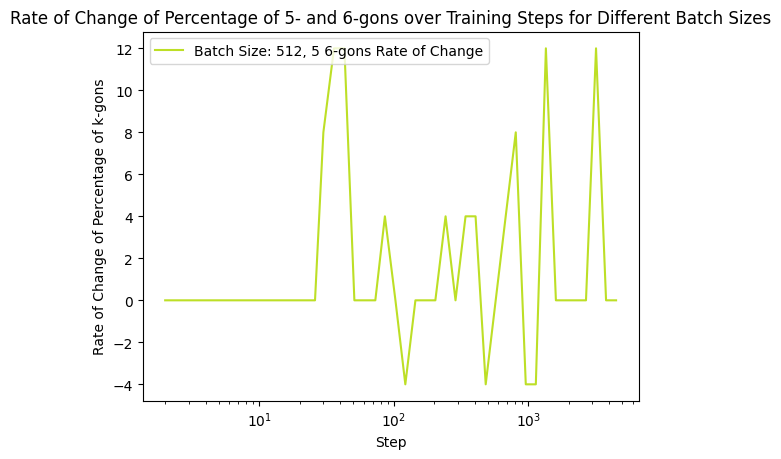

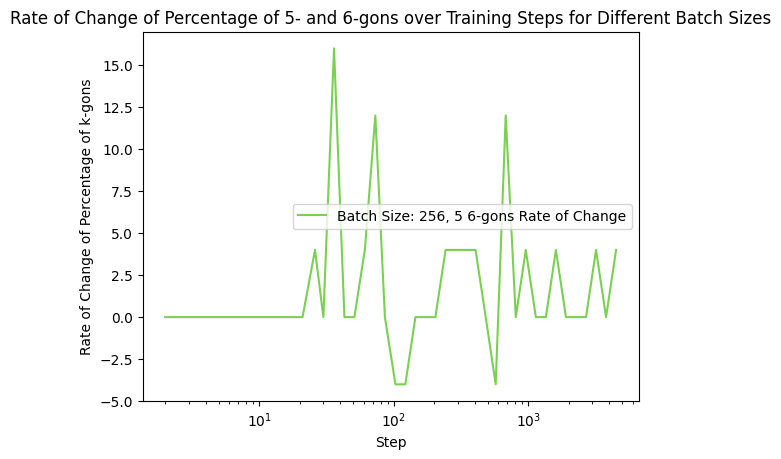

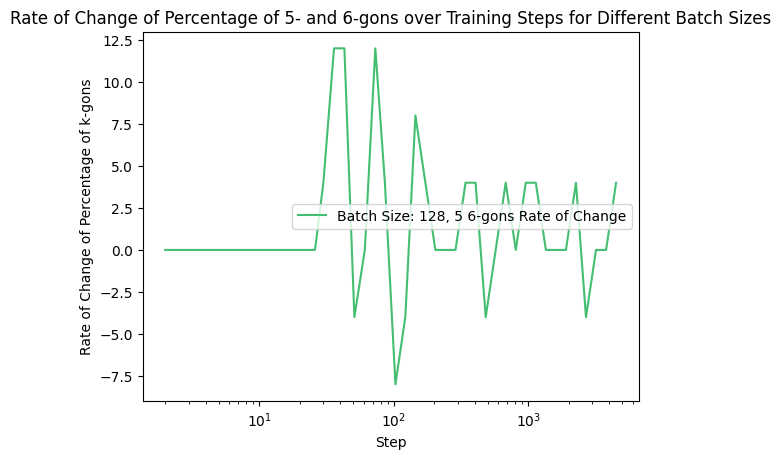

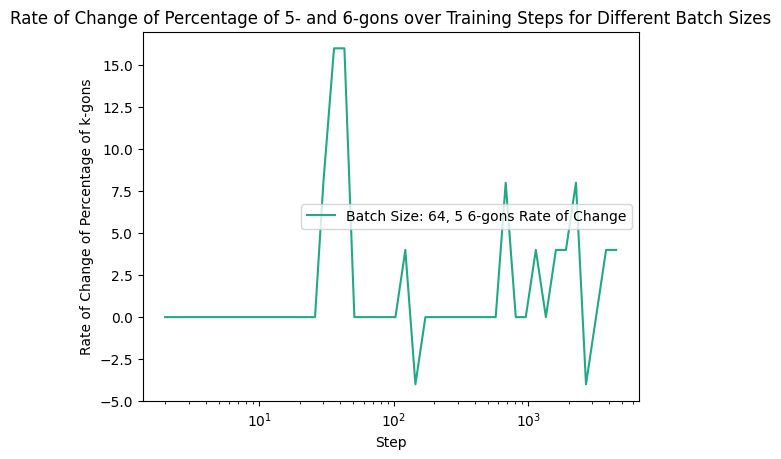

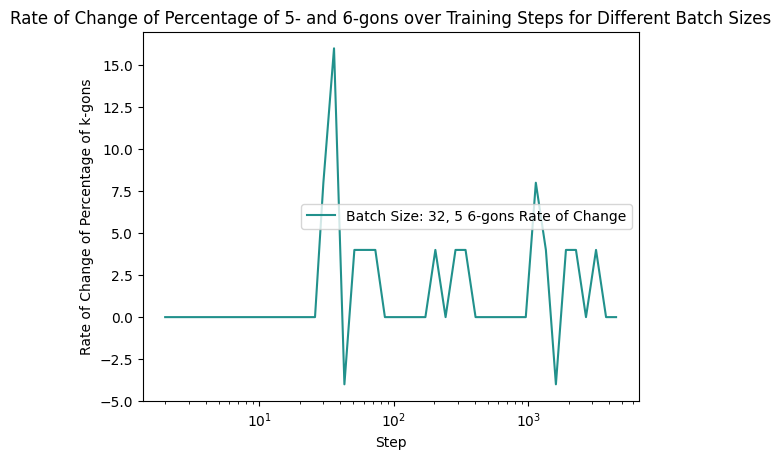

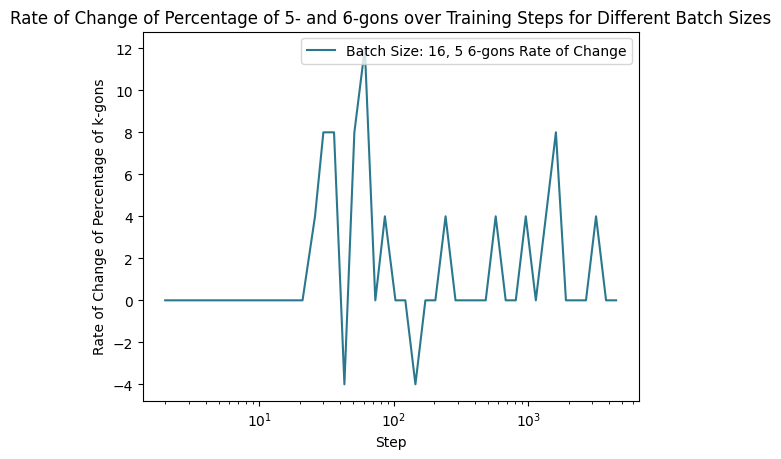

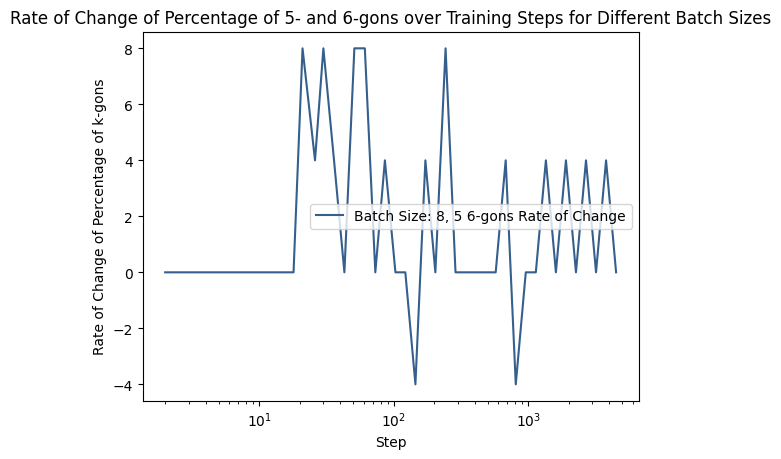

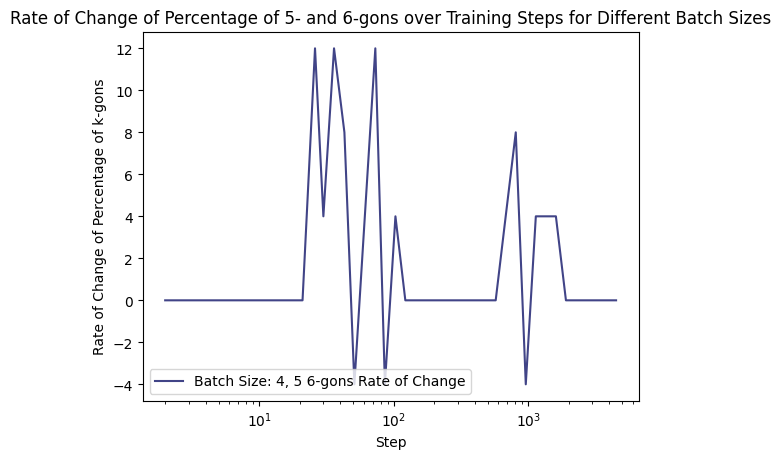

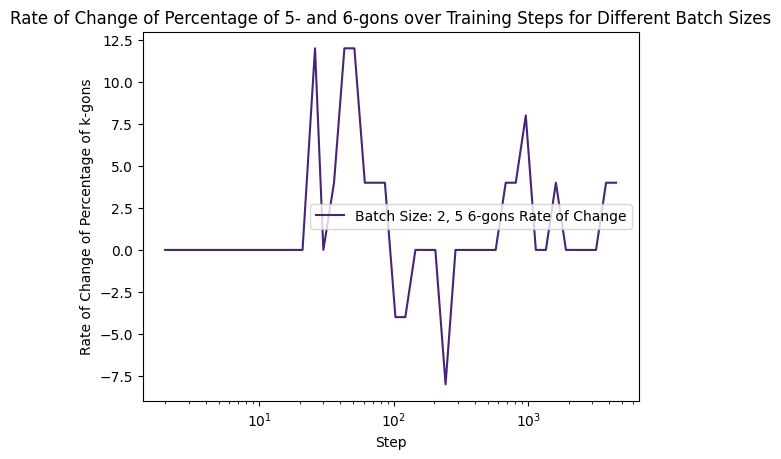

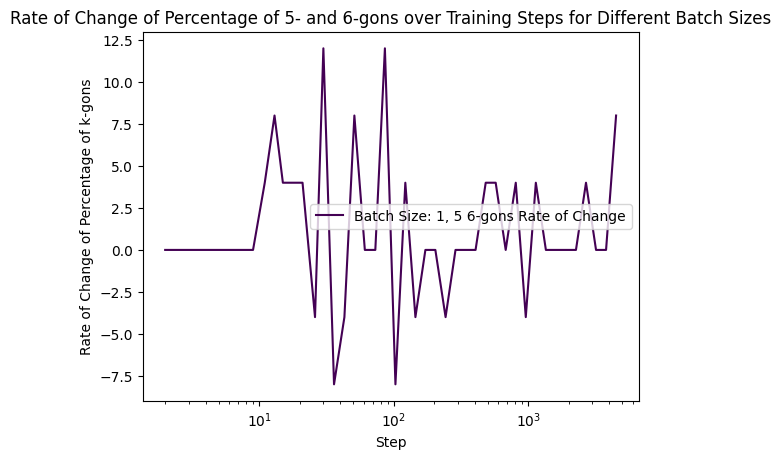

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_rate_of_change_of_kgons(batch_weights, steps, k_values=[5, 6]):
    plt.figure(figsize=(15, 6))
    
    batch_sizes = sorted(batch_weights.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(batch_sizes)))
    
    kgon_percentages = {batch_size: {k: [] for k in k_values} for batch_size in batch_sizes}
    kgon_rate_of_change = {batch_size: {k: [] for k in k_values} for batch_size in batch_sizes}
    
    for batch_size, runs_weights in batch_weights.items():
        color = colors[batch_sizes.index(batch_size)]
        
        for step_weights in zip(*runs_weights):
            edge_counts = count_convex_hull_edges(step_weights)
            total_counts = sum(edge_counts.values())
            
            for k in k_values:
                percentage = (edge_counts.get(k, 0) / total_counts) * 100
                kgon_percentages[batch_size][k].append(percentage)
        
        for k in k_values:
            kgon_rate_of_change[batch_size][k] = np.diff(kgon_percentages[batch_size][k])
        
        rate_of_change = np.zeros(len(steps) - 1)
        for k in k_values:
            rate_of_change += kgon_rate_of_change[batch_size][k]
        label = f'Batch Size: {batch_size}, {" ".join([str(k) for k in k_values])}-gons Rate of Change'
        plt.plot(steps[1:], rate_of_change, label=label, color=color)
    
    plt.xlabel('Step')
    plt.ylabel('Rate of Change of Percentage of k-gons')
    plt.xscale('log')
    plt.title('Rate of Change of Percentage of 5- and 6-gons over Training Steps for Different Batch Sizes')
    plt.legend()
    plt.show()
    
    batch_sizes = sorted(batch_weights.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(batch_sizes)))
    
    kgon_percentages = {batch_size: {k: [] for k in k_values} for batch_size in batch_sizes}
    kgon_rate_of_change = {batch_size: {k: [] for k in k_values} for batch_size in batch_sizes}
    
    for batch_size, runs_weights in batch_weights.items():
        color = colors[batch_sizes.index(batch_size)]
        
        for step_weights in zip(*runs_weights):
            edge_counts = count_convex_hull_edges(step_weights)
            total_counts = sum(edge_counts.values())
            
            for k in k_values:
                percentage = (edge_counts.get(k, 0) / total_counts) * 100
                kgon_percentages[batch_size][k].append(percentage)
        
        for k in k_values:
            kgon_rate_of_change[batch_size][k] = np.diff(kgon_percentages[batch_size][k])
        
        rate_of_change = np.zeros(len(steps) - 1)
        for k in k_values:
            rate_of_change += kgon_rate_of_change[batch_size][k]
        label = f'Batch Size: {batch_size}, {" ".join([str(k) for k in k_values])}-gons Rate of Change'
        plt.plot(steps[1:], rate_of_change, label=label, color=color)
        
        plt.xlabel('Step')
        plt.ylabel('Rate of Change of Percentage of k-gons')
        plt.xscale('log')
        plt.title('Rate of Change of Percentage of 5- and 6-gons over Training Steps for Different Batch Sizes')
        plt.legend()
        plt.show()

# Assuming 'batch_weights' is your dictionary of weights, 'STEPS' is your list of timesteps
plot_rate_of_change_of_kgons(embedding_weights, STEPS)


The above plot seems problematic! We should expect things to go continously up!

In [ ]:
- What would we in theory predict the batch size to do?
- 

In [47]:
batch_losses = {batch_size:[[batch_logs[batch_size][run].loc[batch_logs[batch_size][run]['step'] == s, 'loss'].values[0] for s in STEPS] for run in range(num_runs)] for batch_size in batch_sizes}


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 700 and the array at index 1 has size 7700

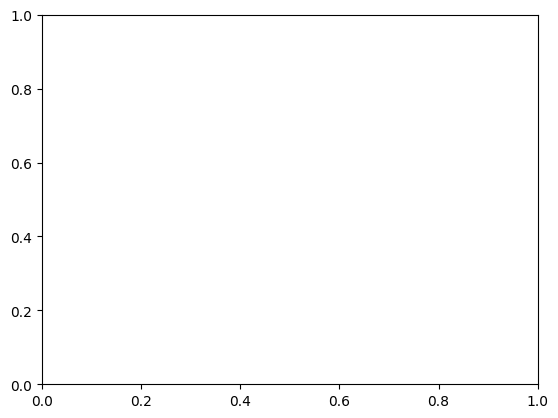

In [49]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

def plot_kgons_loss_density(all_kgons, batch_losses, separate_batches=False):
    fig, ax = plt.subplots()
    
    if separate_batches:
        # If separate_batches is True, plot each batch with a different color
        colors = plt.cm.jet(np.linspace(0, 1, len(batch_losses)))
        for batch_size, runs_losses in batch_losses.items():
            color = colors[list(batch_losses.keys()).index(batch_size)]
            for run_losses in runs_losses:
                xy = np.vstack([all_kgons, run_losses])
                z = gaussian_kde(xy)(xy)
                scatter = ax.scatter(all_kgons, run_losses, c=z, s=50, edgecolor='', cmap='viridis', label=f'Batch Size: {batch_size}')
        ax.legend()
    else:
        # Combine all runs and batch sizes
        combined_kgons = []
        combined_losses = []
        for runs_losses in batch_losses.values():
            for run_losses in runs_losses:
                combined_kgons.extend(all_kgons)
                combined_losses.extend(run_losses)
        
        # Calculate the point density for combined data
        xy = np.vstack([combined_kgons, combined_losses])
        z = gaussian_kde(xy)(xy)
        scatter = ax.scatter(combined_kgons, combined_losses, c=z, s=50, edgecolor='', cmap='viridis')
        plt.colorbar(scatter, ax=ax, label='Density')

    ax.set_xlabel('k-gon')
    ax.set_ylabel('Loss')
    title = 'Density Scatter Plot of k-gon vs. Loss'
    if separate_batches:
        title += ' (Separate Batches)'
    else:
        title += ' (All Batches Combined)'
    ax.set_title(title)
    plt.show()

# Assuming batch_losses is a dictionary with batch sizes as keys and a list of lists as values, where each sublist represents the losses for a run.
# all_kgons is a list of k-gon values you want to plot against these losses.

# Example usage:
plot_kgons_loss_density([3,4,5,6], batch_losses, separate_batches=False)  # Combined plot
plot_kgons_loss_density([3,4,5,6], batch_losses, separate_batches=True)   # Separate plot


In [38]:
NUM_FEATURES = 6
NUM_HIDDEN_UNITS = 2
NUM_SAMPLES = 1024
NUM_EPOCHS = 200000
INIT_KGON = 4
NUM_OBSERVATIONS = 100 #originally 50 

STEPS = sorted(list(set(np.logspace(0, np.log10(NUM_EPOCHS), NUM_OBSERVATIONS).astype(int))))
PLOT_STEPS = [min(STEPS, key=lambda s: abs(s-i)) for i in [0, 200, 500, 1000, NUM_EPOCHS - 1]] #originally [0, 200, 2000, 10000, NUM_EPOCHS - 1]
PLOT_INDICES = [STEPS.index(s) for s in PLOT_STEPS]

In [33]:
batch_logs = {}
batch_weights = {}
batch_sizes = []

for version in ["v1.4.0"]:
    with open(f"results/batch_logs_{version}.pkl", "rb") as f:
        batch_logs.update(pickle.load(f))
    with open(f"results/batch_weights_{version}.pkl", "rb") as f:
        batch_weights.update(pickle.load(f))
    with open(f"results/batch_sizes_{version}.pkl", "rb") as f:
        batch_sizes.extend(pickle.load(f))
        batch_sizes = sorted(list(set(batch_sizes)))

In [34]:
embedding_weights = {k:[[w[i]['embedding.weight'] for i in range(len(w)) if i!=0] for w in b] for k,b in batch_weights.items()}

TODO: fix problem with stepsize.

ValueError: x and y must have same first dimension, but have shapes (39,) and (46,)

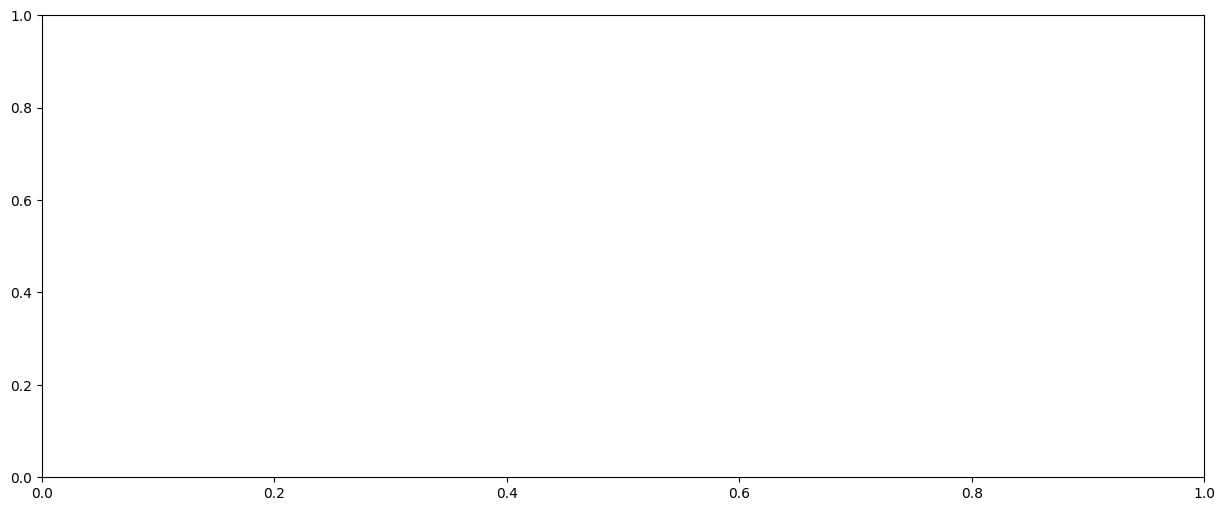

In [20]:
plot_percentage_of_kgons_over_time(embedding_weights, STEPS)


In [17]:

LARGE_NEGATIVE_VALUE= -0.05
#classifying further:
def classify_weights(model):
    W = model.embedding.weight.data.cpu().numpy()
    b = model.unembedding.bias.data.cpu().numpy()

    # Compute the convex hull to determine the number of vertices (k)
    hull = ConvexHull(W.T)
    k = len(hull.vertices)

    # Identify the indices of the k-gon vertices
    k_gon_indices = hull.vertices

    # Count the number of positive biases (σ)
    # This assumes that indices not corresponding to k-gon vertices should have positive biases
    # and that the optimal value is known and defined as OPTIMAL_BIAS_VALUE.
    sigma = sum((b > 0) & (~np.isin(range(len(b)), k_gon_indices)))

    # Count the number of large negative biases (ϕ)
    # This assumes that 'large' is defined, and ϕ is relevant only when k is 4.
    phi = 0
    if k == 4:
        # Assuming LARGE_NEGATIVE_VALUE is defined as the threshold for 'large' negative bias
        phi = sum(b[k_gon_indices] < LARGE_NEGATIVE_VALUE)

    return k, sigma, phi


- TODO: look at garrets neuron experiment to see how to estimate rlct
- TODO: check if things could have been done way faster with higher or lower learning rate